## Notes and resources

https://quantum.cloud.ibm.com/ = dashboard for the IBM Quantum Cloud


Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later with visualization support (`pip install `)
* Qiskit Runtime 0.22 or later (`pip install `)


In [1]:
# autoreload
%load_ext autoreload
%autoreload 2


## Setup


In [2]:
# Qiskit imports
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit.transpiler import Layout

# tutorial at https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/error-correction-repetition-code.ipynb
from mldec.hardware.topological_codes.circuits import RepetitionCode, HardwarePhaseFlipRepetitionCode
from mldec.hardware.topological_codes.fitters import GraphDecoder, lookuptable_decoding

# circuit wrappers and optimizers
from mldec.hardware.topological_codes.wrappers import insert_idle_delays
from mldec.hardware.topological_codes.noise import get_noise

import numpy as np

#### Specify the backend/provider, in order to build a hardware-aware circuit

In [3]:

from qiskit_ibm_runtime.fake_provider import FakeTorino
service = QiskitRuntimeService()
# backend = service.least_busy(simulator=False, operational=True, min_num_qubits=5)
real_backend = service.backend('ibm_torino')
fake_backend = FakeTorino()

In [4]:
# Set the number of qubits and rounds of syndrome measurement.
n = 5
T = 5

# describe an initial state (e.g. |+--+->) for data qubits
initial_state = list(np.random.randint(0, 2, n))
# specify physical qubits on the backend
if n <= 10:
    target_qubits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 18, 31, 30, 29, 28, 27, 26][:2*n-1]

# if delay_factor > 1, we will insert idle delays between some gates.
assert len(np.unique(target_qubits)) == 2*n-1
delay_factor = 1
# we need a template code to do some pre-compilation
template_code = HardwarePhaseFlipRepetitionCode(
    n, T, initial_state=initial_state, backend=fake_backend, delay_factor=delay_factor, target_qubits=target_qubits)

# template_code.circuit.draw(wire_order=template_code.wire_order, fold=999)

### Prepare transpilation and ISA 

In [5]:
from qiskit.transpiler.passes import ALAPScheduleAnalysis
from qiskit.transpiler import PassManager

# The layout was predtermined when initializing the code class.
layout = Layout(input_dict=template_code.qubit_mapping)
# for key, value in template_code.qubit_mapping.items():
#     print(key, value)

# The pass manager should do essentially nothing at this point, assuming I have pre-compiled gates correctly.
pm = generate_preset_pass_manager(
    optimization_level=1, backend=real_backend, 
    layout_method='trivial', routing_method='none', 
    initial_layout=layout)

# Fetch the sampler


In [6]:
# precompose initial states so that I don't have to keep track of them later
def generate_initial_states(n, num_trials, seed=9876):
    np.random.seed(seed)
    train_initial_states = []
    val_initial_states = []
    for trial in range(num_trials):
        train_initial_states.append(list(np.random.randint(0, 2, n)))
        val_initial_states.append(list(np.random.randint(0, 2, n)))
    return train_initial_states, val_initial_states

In [7]:
### RUN THE JOB ###
SUBMIT_JOBS = False
DRAW_CIRCUITS= False
if SUBMIT_JOBS:
    print("Submitting jobs!")
    backend = real_backend
else:
    backend = fake_backend
sampler = Sampler(mode=backend)

# We will specify different initial qubit states, but due to bandwidth issues we run many
# shots per choice of initial state (same as Google 2023 paper).

# TODO: To avoid complicating things and statistical mixtures of things, I'm 
# going to only consider one initial state for now.
num_trials = 1
train_initial_states, val_initial_states = generate_initial_states(n, num_trials)

num_train = 2048
# create a list of the circuit with a different wait time insertion
delay_factors = [1, 2, 5, 10]
training_circuits = []
for trial in range(num_trials):
    initial_state = train_initial_states[trial]
    for delay_factor in delay_factors:
        # initialize a new 
        code = HardwarePhaseFlipRepetitionCode(n, T, initial_state=initial_state, backend=backend, delay_factor=delay_factor, target_qubits=target_qubits)
        print("delay factor=", delay_factor)
        isa_circuit = pm.run(code.circuit)
        if trial == 0 and DRAW_CIRCUITS:
            isa_wire_order = code.wire_order + list(range(2*n-1, len(isa_circuit.qubits) ))
            display(isa_circuit.draw(wire_order=isa_wire_order, fold=999))
        training_circuits.append(isa_circuit)
training_job = sampler.run(training_circuits, shots=num_train)
print("training_job.job_id(): ", training_job.job_id())

# Validation circuit: Just another run
num_val = 8096
validation_circuits = []
for trial in range(num_trials):
    initial_state = val_initial_states[trial]
    code = HardwarePhaseFlipRepetitionCode(n, T, initial_state=initial_state, backend=backend, delay_factor=1, target_qubits=target_qubits)
    isa_circuit = pm.run(code.circuit)
    validation_circuits.append(isa_circuit)
validation_job = sampler.run(validation_circuits, shots=num_val)
print("validation job id:", validation_job.job_id())

delay factor= 1
delay factor= 2
delay factor= 5
delay factor= 10
training_job.job_id():  d9c5eb2d-13ce-4b7f-b0d5-c1b51e06a3e3
validation job id: 5dafa31c-67bf-4a72-91f9-a9178931eeac


### Process the jobs: convert syndromes into DetectorDDD format and save locally.

In [8]:
# this should have length len(delay_factors) * num_initial_states
train_job_result = training_job.result()
# this should have length num_initial_states
val_job_result = validation_job.result()

In [13]:
from mldec.utils.experiments_ibm import process_jobs
from mldec.datasets.reps_exp_rep_code_data import make_exp_dataset_name, save_data

# Convert the nested lists of jobs into a dictionary of the form {beta: (X, Y)}
# this also processes the data into DetectorDDD format
out = process_jobs(n, T, train_job_result, val_job_result, delay_factors, train_initial_states, val_initial_states)

# now save that data locally
# prepare the data for saving
for beta, (X, y) in out.items():
    print(beta)
    fname = make_exp_dataset_name(n, T, beta)
    # reformat to standard shape (n_data, repetitions, n-1)
    if X.shape[0] != 1:
        raise ValueError("X.shape[0] != 1 - haven't implemented trial combinations yet.")
    X = X[0,:,:,:].transpose(1, 0, 2) # (n_data, repetitions, n-1)
    y = y.reshape(-1)
    # for i in range(20, 50):
    #     print(i, X[i], y[i])
    save_data(X, y, fname)
    # check if the di


1
2
5
10
0


### Visualizations

In [21]:
def make_visualization_by_round(X):
    """Make a histogram of the (weights) of (modded) syndromes in the experimental data.
    
    X has shape (n_data, repetitions, n-1). """

    out = np.zeros(X.shape[2] + 1)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            out[int(np.sum(X[i, j]))] += 1
    return out

(2048, 5, 4) (2048,)
(2048, 5, 4) (2048,)
(2048, 5, 4) (2048,)
(2048, 5, 4) (2048,)


Text(0.5, 1.0, 'Histogram of syndrome weights')

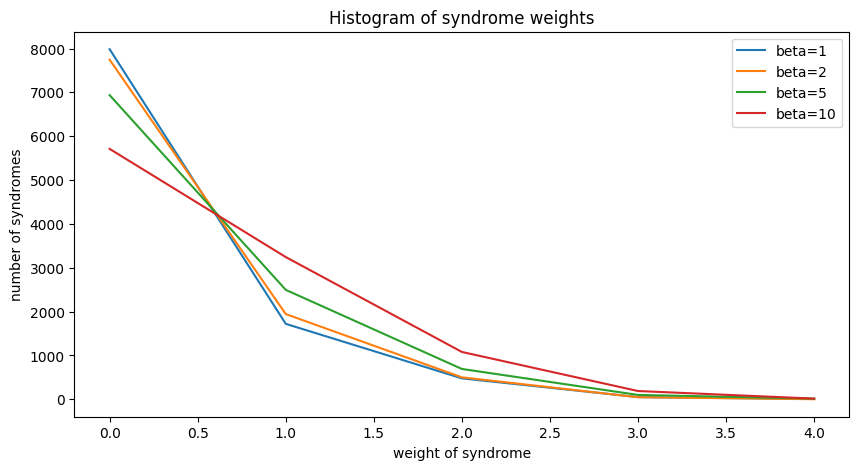

In [23]:
from mldec.datasets.reps_exp_rep_code_data import make_exp_dataset_name, load_data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for beta in [1, 2, 5, 10]:

    fname = make_exp_dataset_name(n, T, beta)
    X, y = load_data(fname)
    print(X.shape, y.shape)
    hist = make_visualization_by_round(X)
    ax.plot(range(len(hist)), hist, label=f"beta={beta}")
ax.legend()
ax.set_xlabel("weight of syndrome")
ax.set_ylabel("number of syndromes")
ax.set_title("Histogram of syndrome weights")


